In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from bitome.core import Bitome
from math import log,exp,inf
# bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')
bitome = Bitome(Path('../bitome-kb/data', 'NC_000913.3.gb'))
bitome.load_data(regulon_db=True)

from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

from feature_functions import *
import pickle
import copy

../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0064
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0142
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
../bitome-kb\bitome\genbank.py:328: UserWarning: No GEM-PRO file found for b4586
  warn(f'No GEM-PRO file found for {locus_tag}')
../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0292
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b0349
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
../bitome-kb\bitome\genbank.py:328: UserWarning: No GEM-PRO file found for b4572
  warn(f'No GEM-PRO f

../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b3963
  warn(f'GEM-PRO sequence and coded sequence are not the same for {locus_tag}')
../bitome-kb\bitome\genbank.py:328: UserWarning: No GEM-PRO file found for b4620
  warn(f'No GEM-PRO file found for {locus_tag}')
../bitome-kb\bitome\genbank.py:328: UserWarning: No GEM-PRO file found for b4621
  warn(f'No GEM-PRO file found for {locus_tag}')
../bitome-kb\bitome\genbank.py:341: UserWarning: Selenocysteine found in GEM-PRO sequence for b4079; Genbank translation audit skipped
  warn(f'Selenocysteine found in GEM-PRO sequence for {locus_tag}; Genbank translation audit skipped')
../bitome-kb\bitome\genbank.py:328: UserWarning: No GEM-PRO file found for b4622
  warn(f'No GEM-PRO file found for {locus_tag}')
../bitome-kb\bitome\genbank.py:345: UserWarning: GEM-PRO sequence and coded sequence are not the same for b4115
  warn(f'GEM-PRO sequence and coded sequence are not the same for {l

In [2]:
#Modified
import ast
# im_info = pd.read_csv('../data/precise2_im_info.csv')
im_info = pd.read_csv('../data/precise1_im_info.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )

# avg_features = pd.read_csv('../data/features_avg.csv')
avg_features = pd.read_csv('../data/features_avg_precise1_plus.csv')

In [3]:
b_g = {}
for g in bitome.genes:
    b_g[g.locus_tag] = g.name

In [4]:
# load regulons
pwm_db = rpwm('../data/motif_pwm_db.txt')

# tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
#           'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
#           'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
#           'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
#           'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
#           'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']

#updated tf_list
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO'
         #[MODIFED] added motif
          ,'BtsR', 'Cbl', 'PyrR', 'ilvY', 'AllR', 'PlaR', 'Zur', 'ZntR', 'RbsR', 'PrpR', 'CueR', 'HprR', 'CusR', 'AtoC']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append(   g.locus_tag )
# convert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[ g.locus_tag ] = g.name

In [5]:
#Precise2 ArcA, Anerobased, Fnr/Fur
import ast
im_info = pd.read_csv('../data/precise2_im_info.csv')

IM_genes2 = {}
for i in range(len(im_info['im_name'])):
    IM_genes2[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


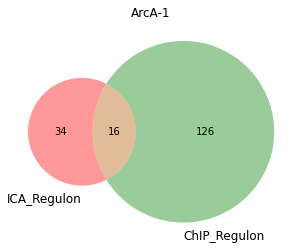

In [6]:
#Modified
from matplotlib_venn import venn2
import matplotlib.font_manager

#ArcA-1
venn2([set(IM_genes['ArcA-1']),set(regulon_genes['ArcA'])],set_labels = ('ICA_Regulon','ChIP_Regulon'))
plt.title('ArcA-1')

# #ArcA-2
# venn2([set(IM_genes['ArcA-2']),set(regulon_genes['ArcA'])],set_labels = ('ICA_Regulon','ChIP_Regulon'))
# plt.title('ArcA-2')

# ArcA-1 + ArcA-2
# ArcA_combined = copy.copy(IM_genes['ArcA-2'])
# ArcA_combined.extend(x for x in IM_genes['ArcA-1'] if x not in IM_genes['ArcA-2'])
# venn2([set(ArcA_combined),set(regulon_genes['ArcA'])],set_labels = ('ICA_Regulon','ChIP_Regulon'))
# plt.title('ArcA_combined')

plt.savefig('../data/Figure 3B.svg', bbox_inches='tight') 

In [7]:
# # Modified [Not use]
# # compare orginal ArcA and ArcA_combined
# import copy

# ArcA_ori = ['b0312', 'b0313', 'b0314', 'b0330', 'b0346', 'b0458', 'b0720', 'b4735', 'b0721', 'b0733', 'b0904', 'b1020',
#  'b1122', 'b1163', 'b1297', 'b1298', 'b1332', 'b1384', 'b1422', 'b1423', 'b1607', 'b1612', 'b1748', 'b1777', 'b1778',
#  'b2150', 'b2181', 'b2210', 'b2310', 'b2518', 'b2537', 'b2587', 'b2844', 'b2980', 'b3351', 'b3408', 'b3409', 'b3453',
#  'b3603', 'b3819', 'b3820', 'b3846', 'b3962', 'b3995', 'b4210', 'b4332', 'b4340']

# test = copy.copy(ArcA_ori)
# test.extend(x for x in ArcA_combined if x not in test) 

# diff=len(ArcA_combined)+len(ArcA_ori)-len(test)
# #24 different genes in comparison to ArcA-1 and ArcA-2 combined

# 1. Get ArcA DR motifs (2DR, 3DR, 4DR) 
* reference:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3798270/


In [8]:
import logomaker as lm
import Bio.motifs as motifs

In [9]:
ArcA_2DR = []
ArcA_3DR = []
ArcA_4DR = []

ArcA_DR = []
ffile = open('../data/ArcA_DR.txt', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    if line[0] == '>':
        continue
    seq = line.strip()
    if len(seq) >40:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_DR.append( seq[33:43])
        ArcA_4DR.append( seq)
    elif len(seq) > 30:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_DR.append( seq[22:32])
        ArcA_3DR.append( seq )
    else:
        ArcA_DR.append( seq[0:10])
        ArcA_DR.append( seq[11:21])
        ArcA_2DR.append( seq )
        ArcA_2DR = list(filter(lambda a: len(a) != 0, ArcA_2DR))
        
ArcA_DR = list(filter(lambda a: len(a) == 10, ArcA_DR))

In [10]:
counts_mat = lm.alignment_to_matrix(ArcA_DR)

In [11]:
M_DR = []
for i in range(len(counts_mat['A']) ):
    SUM = 4+ counts_mat['A'][i]+counts_mat['C'][i]+counts_mat['T'][i]+counts_mat['G'][i]
    
    M_DR.append( {'A':log( (counts_mat['A'][i]+1)/SUM ),
                  'C':log( (counts_mat['C'][i]+1)/SUM ),
                  'G':log( (counts_mat['G'][i]+1)/SUM ),
                  'T':log( (counts_mat['T'][i]+1)/SUM  )   })

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Helvetica


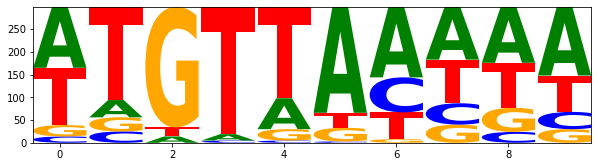

In [12]:
lm.Logo(counts_mat)

In [13]:
cm = {2:lm.alignment_to_matrix(ArcA_2DR),3:lm.alignment_to_matrix(ArcA_3DR),4:lm.alignment_to_matrix(ArcA_4DR)}

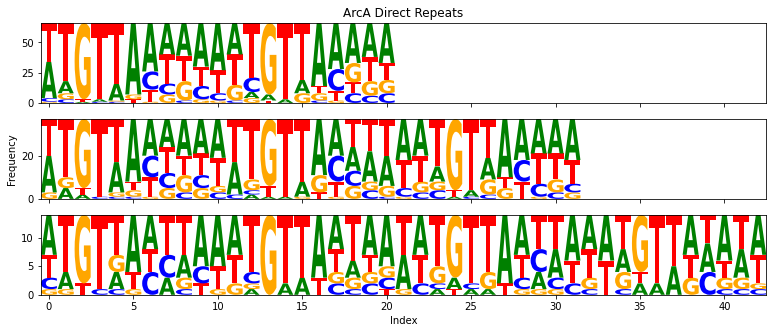

In [14]:
fig, axs = plt.subplots(3,1,figsize=(13,5),sharex=True)
for i in [2,3,4]:
    lm.Logo( cm[i], ax = axs[i-2])
axs[1].set_ylabel('Frequency')
axs[2].set_xlabel('Index')
axs[0].set_title('ArcA Direct Repeats')


plt.savefig('../data/Figure 3A(2).svg', bbox_inches='tight') 

# 2. Generate PSSMs for each DR motif

In [15]:
PWM_DR = {}
for k in cm.keys():
    temp_pwm = []
    temp_cm = cm[k]
    for i in range(len(temp_cm['A']) ):
        SUM = 4+ temp_cm['A'][i]+temp_cm['C'][i]+temp_cm['T'][i]+temp_cm['G'][i]

        temp_pwm.append( {'A':log( (temp_cm['A'][i]+1)/SUM ),
                      'C':log( (temp_cm['C'][i]+1)/SUM ),
                      'G':log( (temp_cm['G'][i]+1)/SUM ),
                      'T':log( (temp_cm['T'][i]+1)/SUM  )   })
    PWM_DR[k] = temp_pwm

PWM_DR[1] = M_DR

In [16]:
no_signal = { 'A':log(0.25) , 'C':log(0.25) ,'G':log(0.25), 'T':log(0.25)}
PWM_DR_avg = {}
for k in PWM_DR.keys():
    PWM_DR_avg[k] =  M_DR.copy()
    for i in range( int(k-1)):
        PWM_DR_avg[k].append( no_signal )
        PWM_DR_avg[k] =  PWM_DR_avg[k] +  M_DR       

In [17]:
from feature_functions import *
N_UPSTREAM  = 150
N_DOWNSTREAM = 30

# 3.  Compute new feature matrix for ArcA DR motifs

In [18]:
def match1DR( tss, strand , bitome_obj, N_UPSTREAM, N_DOWNSTREAM, M, DR_num, cutoff ):
     # N is the number of DRs to match
    if strand == 1:
        
        locs = np.arange(tss - N_UPSTREAM, tss + N_DOWNSTREAM + 1)
        bp_to_tss = np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1)
        
        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_UPSTREAM - 1,
            tss + N_DOWNSTREAM,
            strand
        )
        
    else:

        locs = np.arange(tss - N_DOWNSTREAM, tss + N_UPSTREAM + 1)
        bp_to_tss = np.flip(np.arange(-N_UPSTREAM, N_DOWNSTREAM + 1))

        # define the sequence feature location to extract the sequence around this TSS
        seq_loc = FeatureLocation(
            tss - N_DOWNSTREAM - 1,
            tss + N_UPSTREAM,
            strand
        )
    DR_scores = []
    sequence = seq_loc.extract(bitome_obj.sequence)
    for i in range(len(sequence) - len(M) + 1):
        subbox = sequence[i:i+ len(M) ]
        DR_scores.append( score_motif(subbox,M) )# store tuple( score,index )
        
    max_score =  max( DR_scores )
    ind = DR_scores.index( max_score )
    mid = ind + len(M)/2  
    distTSS = abs(N_UPSTREAM - mid )
    if mid < N_UPSTREAM:
        up = 1
    else:
        up = 0
    result = {}
    result[str(DR_num)+'DR_score'] = max_score
    result[str(DR_num)+'DR_distTSS'] = distTSS
    result[str(DR_num)+'DR_upstream'] = up
    result['seq'] = str(sequence)
    
    if max_score > cutoff[DR_num ]:
        result[ str(DR_num)+'DR_abovecutoff' ] = 1
    else:
        result[ str(DR_num)+'DR_abovecutoff' ] = 0
        
    return result

In [20]:
# # load regulons
# pwm_db = rpwm('../data/motif_pwm_db.txt')

# # <MODIFIED> Added manually constructed motif without alignment
# tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
#           'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
#           'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
#           'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
#           'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
#           'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO'
#          # [MODIFIED] Added ones
#          ,'BtsR', 'Cbl', 'PyrR', 'IlvY', 'AllR', 'PlaR', 'Zur', 'ZntR', 'RbsR', 'PrpR', 'CueR', 'HprR', 'CusR', 'AtoC']

# # [MODIFIED]: accounting for synonymous naming
# regulon_genes={}
# for TF in bitome.transcription_factors:
#     #print(TF.name)
#     # Only include the TF that is included in the tf_list, those are the tf that we have logodds and pwm data.
#     if TF.name == 'YpdB':
#         tfname = 'PyrR'
#     elif TF.name == 'YehT':
#         tfname = 'BtsR'
#     elif TF.name == 'YiaJ':
#         tfname = 'PlaR'
#     elif TF.name == 'YedW':
#         tfname = 'HprR'
#     else:
#         tfname = TF.name
#     if tfname in tf_list:
#         regulon_genes[tfname] = []   
#         for r in TF.regulons:
#                 for p in list(r.regulated_promoters.values())[0]:
#                     if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
#                         for g in p.transcription_unit.genes:
#                             regulon_genes[tfname].append( g.locus_tag)
                            
# # convert gene name and b number.
# b_g = {}
# for g in bitome.genes:
#     b_g[ g.locus_tag ] = g.name

In [19]:
# cutoff values for each DR
cutoff = { 1: -8.4 ,2: -23.3628,3: -38.44,4:-52.94}

In [22]:
# [MODIFIED] 
# bitome.genebank_record = SeqIO.read('../bitome-kb/NC_000913.3.gb', 'gb')
# bitome.sequence = SeqIO.read('../bitome-kb/NC_000913.3.gb', 'gb').seq
# Set direct bitome sequence or this would cause Attribute: "_data" error
# bitome.sequence

In [20]:
ArcA_data = []
for g in bitome.genes:
    
    if len(g.transcription_units) < 1:
        continue
        
    for tu in g.transcription_units:
        if tu.tss == None or int(tu.tss) < 200:
            continue
        data = {}
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        data['strand'] = int(tu.location.strand)
        for k in PWM_DR.keys():
            data.update(match1DR(tu.tss,  int(tu.location.strand), bitome, N_UPSTREAM, N_DOWNSTREAM, PWM_DR[k], int(k), cutoff))
        
        ArcA_data.append(data)

In [21]:
DR_table = pd.DataFrame( ArcA_data )

In [22]:
DR1score = []
DR2score = []
DR3score = []
DR4score = []
for i in range(len( DR_table['gene'])):
    if list(DR_table['ID'])[i] in regulon_genes['ArcA']:
        DR1score.append( list( DR_table['1DR_score'])[i] )
        DR2score.append( list( DR_table['2DR_score'])[i] )
        DR3score.append( list( DR_table['3DR_score'])[i] )
        DR4score.append( list( DR_table['4DR_score'])[i] )

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


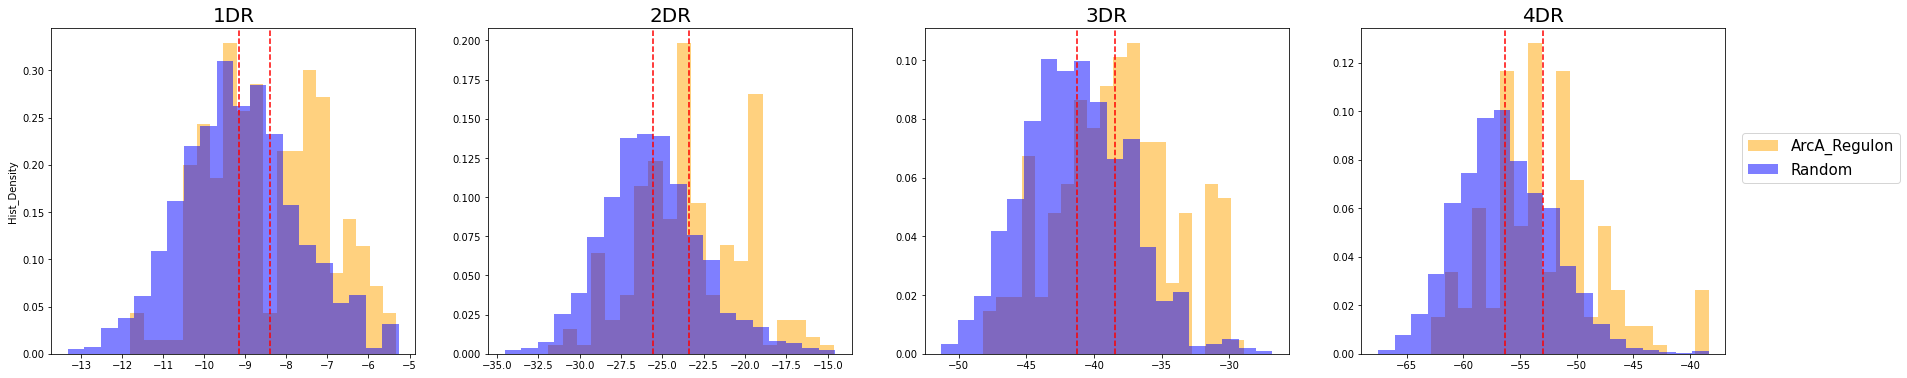

In [23]:
from scipy import stats
import matplotlib.font_manager
fig,axs = plt.subplots(1,4, figsize = (30,6))

axs[0].hist(DR1score,density=True,bins=20, alpha=0.5,color ='orange')
axs[0].hist(list( DR_table['1DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[0].axvline( x= sum(DR_table['1DR_score'])/len(DR_table['1DR_score']), color = 'r', ls = '--')
axs[0].axvline( x= sum(DR1score)/len(DR1score), color = 'r', ls = '--')
axs[0].set_ylabel('Hist_Density')

axs[1].hist(DR2score,density=True, bins=20, alpha=0.5,color ='orange')
axs[1].hist(list( DR_table['2DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[1].axvline( x= sum(DR_table['2DR_score'])/len(DR_table['2DR_score']), color = 'r', ls = '--')
axs[1].axvline( x= sum(DR2score)/len(DR2score), color = 'r', ls = '--')

axs[2].hist(DR3score,density=True, bins=20, alpha=0.5,color ='orange')
axs[2].hist(list( DR_table['3DR_score']),density=True,bins=20, alpha=0.5,color ='b')
axs[2].axvline( x= sum(DR_table['3DR_score'])/len(DR_table['3DR_score']), color = 'r', ls = '--')
axs[2].axvline( x= sum(DR3score)/len(DR3score), color = 'r', ls = '--')

axs[3].hist(DR4score,density=True,bins=20,  alpha=0.5,color ='orange',label = 'ArcA_Regulon')
axs[3].hist(list( DR_table['4DR_score']),density=True, bins=20, alpha=0.5,color ='b',label = 'Random')
axs[3].axvline( x= sum(DR_table['4DR_score'])/len(DR_table['4DR_score']), color = 'r', ls = '--')
axs[3].axvline( x= sum(DR4score)/len(DR4score), color = 'r', ls = '--')
axs[3].legend(loc='lower right', fontsize=15, bbox_to_anchor=(1.5, 0.5))

for i in range(4):
    axs[i].set_title(str(i+1)+'DR',fontsize = 20)

# 4. ML

In [24]:
temp_DR = DR_table.drop(['seq'],axis=1)

In [25]:
unique_ids = np.unique(list(temp_DR['ID']))

multiple_ids = {}
for n in unique_ids:
    if list(temp_DR['ID']).count(n) > 1:
        multiple_ids[n] = list(temp_DR['ID']).count(n)

remove_list = []
length = len(temp_DR['ID'])
for i in range(length):
    if temp_DR.iloc[i,0] in multiple_ids.keys():
        remove_list.append(i)

single_DR = temp_DR.drop(remove_list)
single_DR = single_DR.reset_index()
single_DR = single_DR.drop(columns=['index'])
single_DR= single_DR[['ID']+list(single_DR.columns)[3:]]

featureList = list(single_DR.columns)[1:]
multi = {}
for g in multiple_ids.keys():
    multi[g] = {}
    multi[g]['ID'] = str(g)
    for f in featureList:
        multi[g][f] = 0
        
for i in range(len(temp_DR['ID']) ):
    if temp_DR['ID'][i] in multiple_ids.keys():
        for f in featureList:
            multi[ str(temp_DR['ID'][i]) ][f] += float(temp_DR[f][i]/multiple_ids[str(temp_DR['ID'][i])])
            
multi_table = []
for k in multi.keys():
    multi_table.append(multi[k])
multi_pd = pd.DataFrame(multi_table)

avg_DR = single_DR.append(multi_pd)
avg_DR=avg_DR.reset_index()
avg_DR=avg_DR.drop(columns=['index'])
avg_DR.head()

,ID,strand,2DR_score,2DR_distTSS,2DR_upstream,2DR_abovecutoff,3DR_score,3DR_distTSS,3DR_upstream,3DR_abovecutoff,4DR_score,4DR_distTSS,4DR_upstream,4DR_abovecutoff,1DR_score,1DR_distTSS,1DR_upstream,1DR_abovecutoff
0,b0008,1.0,-26.782829,135.5,1.0,0.0,-42.126282,130.0,1.0,0.0,-58.358297,124.5,1.0,0.0,-8.326755,111.0,1.0,1.0
1,b0025,1.0,-28.706138,12.5,0.0,0.0,-45.930994,66.0,1.0,0.0,-58.313623,60.5,1.0,0.0,-10.507677,144.0,1.0,0.0
2,b0034,1.0,-26.100094,6.5,0.0,0.0,-39.136347,12.0,0.0,0.0,-54.037956,79.5,1.0,0.0,-8.097136,26.0,0.0,1.0
3,b0035,-1.0,-24.149415,89.5,1.0,0.0,-38.932659,133.0,1.0,0.0,-56.369400,127.5,1.0,0.0,-7.250062,133.0,1.0,1.0
4,b0036,-1.0,-24.149415,89.5,1.0,0.0,-38.932659,133.0,1.0,0.0,-56.369400,127.5,1.0,0.0,-7.250062,133.0,1.0,1.0


In [26]:
X_DR = avg_DR.iloc[:,1:].values
X_DR = StandardScaler().fit_transform(X_DR)
ID = list(avg_DR['ID'])
# generate labels, classify im membership
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )
            
ArcA_reg_lab = []
for i in range( len(ID) ):
    if ID[i] in regulon_genes['ArcA']:
        ArcA_reg_lab.append( 1 )
    else:
        ArcA_reg_lab.append( 0 )

In [30]:
# # Modified [Not Use]
# #generate target_labels for ArcA_combined

# ArcA_combined_labels=[]
# for i in range( len(ID) ):
#     if ID[i] in ArcA_combined:
#         ArcA_combined_labels.append( 1 )
#     else:
#         ArcA_combined_labels.append( 0 )

In [27]:
# Modified
y_to_try = {
#     'ArcA':target_labels['ArcA'],
    'ArcA-1':target_labels['ArcA-1'],
    'ArcA-2':target_labels['ArcA-2'],
#     'ArcA_combined':ArcA_combined_labels,
    'ArcA_regulon':ArcA_reg_lab
}
models_to_try = {
    'LR': LogisticRegression(
#         penalty='l1',
        penalty = 'elasticnet',
        l1_ratio = 0.5,
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [28]:
# Modified
import pickle
with open('../data/promoters_grouping_IM.pkl', 'rb') as f:
    IM_promoters = pickle.load(f)
with open('../data/promoters_grouping_All.pkl', 'rb') as f:
    All_promoters = pickle.load(f)

In [ ]:
# # use promoter space LOO instead of 5-fold cv

# result_df = pd.DataFrame(
#     columns=['model', 'im', 'train_auc', 'test_auc']
# )

# N_CV = 5

# for model_name, model in models_to_try.items():
#     print(f'{model_name}')
    
#     for y_name, y_labels in y_to_try.items():
#         print(f'{model_name}: {y_name}')
        
#         cv_result = cross_validate(
#             model,
#             X_DR,
#             y= y_labels,
#             cv=N_CV,
#             scoring='roc_auc',
#             return_train_score=True,
#             verbose=1,
#             n_jobs=4
#         )

#         sub_result_df = pd.DataFrame(
#             data={
#                 'model': [model_name] * N_CV,
#                 'im': [y_name] * N_CV,
#                 'train_auc': cv_result['train_score'],
#                 'test_auc': cv_result['test_score']
#             }
#         )

#         result_df = result_df.append(sub_result_df)

In [ ]:
# # [Not Use]
# _, ax = plt.subplots()
# sns.boxplot(x='model', y='test_auc', data=result_df, hue='im', dodge=True, ax=ax)
# plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'purple', ls = '--')

# Hyperparameters Optimization (SKIP due to overfitting)

In [ ]:
# [Not Use]
# hyperopt_models = {
#     'LR': {
#         'model': LogisticRegression(
#             solver='liblinear',
#             class_weight='balanced',
#             verbose=1
#         ),
#         'param_dists': {
#             'penalty': ['l1', 'l2'],
#             'C': np.logspace(-1,2,15),
#             'max_iter':np.array([1000])
#         }
#     }
# }

In [ ]:
# [Not Use]
# hyperopt_LR = {}

# for y_name, y_labels in y_to_try.items():
#     print(y_name)

#     random_search_hyperopt = RandomizedSearchCV(
#         hyperopt_models['LR']['model'],
#         hyperopt_models['LR']['param_dists'],
#         n_iter=25,
#         scoring='roc_auc',
#         n_jobs=4,
#         cv=5,
#         verbose=1,
#         return_train_score=True
#     )

#     random_search_hyperopt.fit(X_DR,y_labels )
    
#     hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
#         by='mean_test_score',
#         ascending=False
#     )
#     hyperopt_LR[y_name] = hyperopt_results_df

In [ ]:
# [Not Use]
# # combine all the hyperopt results into a DF
# dfs_with_ims = []
# for y_name, hyperopt_df in hyperopt_LR.items():
#     hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
#     dfs_with_ims.append(hyperopt_df)
    
# hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

In [ ]:
# [Not Use]
# hyperopt_LR_df.to_csv('../data/ArcA_DR_LRopt.csv')

In [ ]:
# [Not Use]
# fig = plt.figure(figsize=(3,4))
# sns.swarmplot(x='im', y='mean_test_score', data=hyperopt_LR_df)
# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'purple', ls = '--')

In [ ]:
# Not Use

# hyperopt_LR_old = {}

# for y_name, y_labels in y_to_try.items():
#     print(y_name)

#     random_search_hyperopt = RandomizedSearchCV(
#         hyperopt_models['LR']['model'],
#         hyperopt_models['LR']['param_dists'],
#         n_iter=25,
#         scoring='roc_auc',
#         n_jobs=4,
#         cv=5,
#         verbose=1,
#         return_train_score=True
#     )

#     random_search_hyperopt.fit(X,y_labels )
    
#     hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
#         by='mean_test_score',
#         ascending=False
#     )
#     hyperopt_LR_old[y_name] = hyperopt_results_df

# # combine all the hyperopt results into a DF
# dfs_with_ims = []
# for y_name, hyperopt_df in hyperopt_LR_old.items():
#     hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
#     dfs_with_ims.append(hyperopt_df)
    
# hyperopt_LR_old_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

In [ ]:
# [Not Use]
# fig,axs = plt.subplots(1,2,figsize=(6,4))
# axs[0]=sns.boxplot(x='im', y='mean_test_score', data=hyperopt_LR_df,ax=axs[0])
# axs[0].axhline(y= 0.5, color = 'r', ls = '--')
# axs[0].axhline(y= 0.8, color = 'purple', ls = '--')
# axs[0].set_title('LR_DR_motif')

# axs[1]=sns.boxplot(x='im', y='mean_test_score', data=hyperopt_LR_old_df,ax=axs[1])
# axs[1].axhline(y= 0.5, color = 'r', ls = '--')
# axs[1].axhline(y= 0.8, color = 'purple', ls = '--')
# axs[1].set_title('LR_ChIP_motif')
# for ax in axs:
#     ax.set_yticks(np.arange(0.4,1,0.05))
#     ax.set_xticks( np.array( [0,1]) )
# fig.tight_layout(pad=1.0)


In [29]:
to_try = {}
to_try['ArcA-1'] = target_labels['ArcA-1']
to_try['ArcA-2'] = target_labels['ArcA-2']

In [30]:
def resample_5v(oversampler, features_table, num_neighbors=5, SMOTE_only = True, exact_repeats_boost=0.1,
                target_labels=target_labels, reduced_ratio=1, N_CV=5
                ):
    '''
    oversampler: selected oversampling method from imblearn
    undersampler: selected undersamplig method from imblearn
    num_neighbor: Number of k-nearest neighbor used to perform SMOTE oversampling
    reduced_ratio: If undersample=True, the ratio of the n_negative_aftersampling to n_negative_beforesampling. Should be 
    set to 1 if undersampling=False
    
    '''
    
    result_df = pd.DataFrame(
        columns=['model', 'im', 'train_auc', 'test_auc']
    )

    for model_name, model in models_to_try.items():

        for IM_name, y_labels in to_try.items():

            # skip the promoters that are too small
            if len(IM_promoters[IM_name])<N_CV:
                continue
            
            #index_num = 0
            print(f'{model_name}: {IM_name}')

            temp_eng_features = features_table.copy()
            temp_eng_features['label'] = y_labels        

            ingroup_set = IM_promoters[IM_name]
            outgroup_set = [l for l in All_promoters if not any(item in l for item in sum(IM_promoters[IM_name], [])) ]
            
#             random.Random(4).shuffle(outgroup_set) 
#             leave_one_out_set = ingroup_set + outgroup_set[:len(ingroup_set)]
#             pure_training_set = outgroup_set[len(ingroup_set):]

            # only include unique samples in pure training set
#             pure_training_set = [l[0] for l in pure_training_set]

            kf = KFold(n_splits=N_CV)

            train_scores = []
            test_scores = []
            
            for (out_index, in_index) in zip(kf.split(outgroup_set), kf.split(ingroup_set)):

                # using sum here to flatten the list in list 
                
                test_promoters_out = sum([outgroup_set[i] for i in out_index[1]], [])          
                train_promoters_out = sum([outgroup_set[i] for i in out_index[0]], [])
                
                test_promoters_in = sum([ingroup_set[i] for i in in_index[1]], [])          
                train_promoters_in = sum([ingroup_set[i] for i in in_index[0]], [])
                
                test_promoters = test_promoters_out + test_promoters_in
                train_promoters = train_promoters_out + train_promoters_in
                
                train_X = temp_eng_features.loc[train_promoters].iloc[:, :-1]
                test_X = temp_eng_features.loc[test_promoters].iloc[:, :-1]

                train_Y = temp_eng_features.loc[train_promoters, 'label']
                test_Y = temp_eng_features.loc[test_promoters, 'label']
            
            
                if SMOTE_only == True:
                    # Only use RandomOverSampling to boost the samples number over num_neighbors+1
                    if len([l for l in train_Y if l==1])<=num_neighbors:
                        
                        exact_repeats_boost = (num_neighbors+1)/len([l for l in train_Y if l==0])                
                        rs = RandomOverSampler(sampling_strategy = exact_repeats_boost)
                        train_X, train_Y = rs.fit_sample(train_X, train_Y)
                    
                else:
                    # Use RandomOverSampling to boost the positive samples number to a certain pos/neg ratio.
                    rs = RandomOverSampler(sampling_strategy = exact_repeats_boost)
                    train_X, train_Y = rs.fit_sample(train_X, train_Y)
                
                
                if exact_repeats_boost != 1:
                    # Oversampling by SMOTE
                    if oversampler == SMOTETomek:
                        over = oversampler(sampling_strategy = reduced_ratio, smote = SMOTE(k_neighbors = num_neighbors))
#                         train_X, train_Y = over.fit_sample(train_X, train_Y)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                        
                    else:
                        over = oversampler(sampling_strategy = reduced_ratio, k_neighbors = num_neighbors)
#                         train_X, train_Y = over.fit_sample(train_X, train_Y)
                        train_X, train_Y = over.fit_resample(train_X, train_Y)
                    

#                 # undersampling by ClusterCentroids
#                 # undersample negative samples until the number of two classes are the same
                
#                 if undersampler!= None and reduced_ratio!=1:
#                     under = undersampler(sampling_strategy = 'majority') 
#                     train_X, train_Y = under.fit_sample(train_X, train_Y)      
                
                #print('size of training set', train_X.shape[0]) 
                
                model.fit(train_X, train_Y)

                if model_name == 'SVM':
                    train_auc = roc_auc_score(train_Y, model.decision_function(train_X))
                    test_auc = roc_auc_score(test_Y, model.decision_function(test_X))

                else:
                    train_auc = roc_auc_score(train_Y, model.predict_proba(train_X)[:,1])
                    test_auc = roc_auc_score(test_Y, model.predict_proba(test_X)[:,1])

                train_scores.append(train_auc)
                test_scores.append(test_auc)
                
                
            sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [IM_name] * N_CV,
                'train_auc': train_scores,
                'test_auc': test_scores
            }

            )
            
            # PCA evaluation of resampling
#             pca = PCA(2)
#             pca_data = pd.DataFrame(pca.fit_transform(train_X),columns=['PC1','PC2']) 
#             pca_data['label'] = train_Y
#             sns.scatterplot(x="PC1",y="PC2",hue="label", data=pca_data)
#             plt.title('After resampling for '+ IM_name)
#             plt.show()  

            #index_num += 1
            result_df = result_df.append(sub_result_df)

    return result_df

In [31]:
#Modified
X_DR_df = pd.DataFrame(X_DR, index = avg_DR['ID'], columns=avg_DR.columns[1:])
eng_features_stdd = pd.read_csv('../data/eng_features_stdd_table.csv')
motif_only_df = pd.read_csv('../data/motif_only_table.csv', index_col=0)
eng_features_stdd.set_index(eng_features_stdd['ID'], drop=True, inplace = True)
eng_features_stdd = eng_features_stdd.drop(columns = ['ID'])

X_DR_new = pd.concat([eng_features_stdd, X_DR_df.set_index(eng_features_stdd.index)], axis=1)

In [32]:
# Modified
# re-run old result for ArcA-1 and ArcA-2

from sklearn.metrics import accuracy_score
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

result_df_ori = resample_5v(oversampler=SMOTETomek, features_table=eng_features_stdd, num_neighbors=5, SMOTE_only = True, exact_repeats_boost=0.1,
                target_labels=target_labels, reduced_ratio=1, N_CV=5)

LR: ArcA-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


SVM: ArcA-1
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


SVM: ArcA-2
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


RF: ArcA-1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RF: ArcA-2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [33]:
# Modified
result_df_new = resample_5v(oversampler=SMOTETomek, features_table=X_DR_new, num_neighbors=5, SMOTE_only = True, exact_repeats_boost=0.1,
                target_labels=target_labels, reduced_ratio=1, N_CV=5)

LR: ArcA-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


SVM: ArcA-1
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


SVM: ArcA-2
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


RF: ArcA-1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RF: ArcA-2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [34]:
# Modified
result_df_motif = resample_5v(oversampler=SMOTETomek, features_table=motif_only_df, num_neighbors=5, SMOTE_only = True, exact_repeats_boost=0.1,
                target_labels=target_labels, reduced_ratio=1, N_CV=5)

LR: ArcA-1


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


LR: ArcA-2


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


SVM: ArcA-1
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


SVM: ArcA-2
[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.


[LibLinear]

Liblinear failed to converge, increase the number of iterations.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RF: ArcA-1


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Us

RF: ArcA-2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [ ]:
# #original code
# before_score = list(hyperopt_LR_old_df[hyperopt_LR_old_df['im']=='ArcA']['mean_test_score'])
# after_score = list(hyperopt_LR_df[hyperopt_LR_df['im']=='ArcA']['mean_test_score'])
# score_list = before_score+after_score
# model_state = ['Before(ChIP_motif)' for i in range(25)] + ['After(DR_motif)' for i in range(25)]
# plt.figure(figsize=(5,5))
# sns.boxplot(x=model_state,y=score_list,width=0.5)
# plt.title("ArcA ICA Regulon Prediction")
# plt.ylabel("AUC_ROC")
# plt.ylim([0.4,1.01])
# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'r', ls = '--')

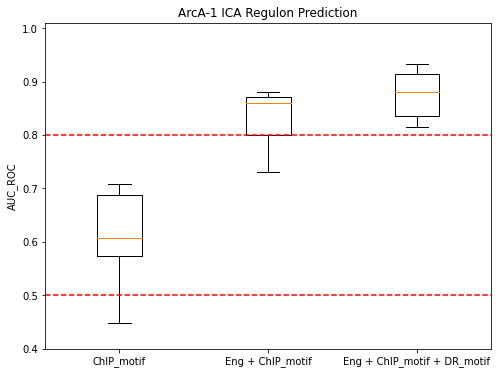

In [35]:
# Modified
#ArcA-1 uses LR model

# before_score = list(hyperopt_LR_old_df[hyperopt_LR_old_df['im']=='ArcA']['mean_test_score'])
# after_score = list(hyperopt_LR_df[hyperopt_LR_df['im']=='ArcA']['mean_test_score'])

# result_df = result_df[result_df['model'] != 'RF']
# result_df = result_df[result_df['model'] != 'SVM']
result_df_ori = result_df_ori[result_df_ori['model'] != 'RF']
result_df_ori = result_df_ori[result_df_ori['model'] != 'SVM']
result_df_new = result_df_new[result_df_new['model'] != 'RF']
result_df_new = result_df_new[result_df_new['model'] != 'SVM']
result_df_motif = result_df_motif[result_df_motif['model']=='LR']

# before_score = list(result_df[result_df['im']=='ArcA-1']['test_auc'])
before_score = list(result_df_ori[result_df_ori['im']=='ArcA-1']['test_auc'])
after_score = list(result_df_new[result_df_new['im']=='ArcA-1']['test_auc'])
motif_score = list(result_df_motif[result_df_motif['im']=='ArcA-1']['test_auc'])

ArcA1_box = {'ChIP_motif': motif_score, 'Eng + ChIP_motif': before_score, 'Eng + ChIP_motif + DR_motif':after_score}

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(ArcA1_box.values())
ax.set_xticklabels(ArcA1_box.keys())

# plt.figure(figsize=(5,5))
# sns.boxplot(x=model_state,y=score_list,width=0.5)
plt.title("ArcA-1 ICA Regulon Prediction")
plt.ylabel("AUC_ROC")
plt.ylim([0.4,1.01])
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.savefig('../data/Figures/Figure 3C.svg', bbox_inches='tight') 

In [ ]:
# # Modified [Not Use]
# #ArcA-2 uses SVM model

# result_df_ori = result_df_ori[result_df_ori['model'] != 'RF']
# result_df_ori = result_df_ori[result_df_ori['model'] != 'SVM']
# result_df_new = result_df_new[result_df_new['model'] != 'RF']
# result_df_new = result_df_new[result_df_new['model'] != 'SVM']

# before_score = list(result_df_ori[result_df_ori['im']=='ArcA-2']['test_auc'])
# after_score = list(result_df_new[result_df_new['im']=='ArcA-2']['test_auc'])
# ArcA1_box = {'Before(ChIP_motif)': before_score, 'After(DR_motif)':after_score}

# fig, ax = plt.subplots()
# ax.boxplot(ArcA1_box.values())
# ax.set_xticklabels(ArcA1_box.keys())
# plt.title("ArcA-2 ICA Regulon Prediction")
# plt.ylabel("AUC_ROC")
# plt.ylim([0.4,1.01])
# plt.axhline(y= 0.5, color = 'r', ls = '--')
# plt.axhline(y= 0.8, color = 'r', ls = '--')

In [36]:
import shap
from sklearn.model_selection import train_test_split
DR_features= list(avg_DR.columns[1:])

In [37]:
# Modified
# X_DR without im score

X_DR_no_im = copy.copy(X_DR_new)
X_DR_no_im = X_DR_no_im.drop(columns = ['ArcA-1 im score', 'ArcA-1 im_shape_ld','ArcA-2 im score', 'ArcA-2 im_shape_ld'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 334 epochs took 3 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


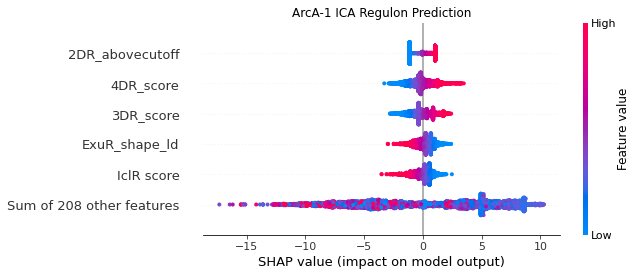

In [38]:
# Modified
# ArcA-1 features 

reduced_ratio=1
num_neighbors=5

clf_ica = LogisticRegression(solver='saga',penalty = 'elasticnet', l1_ratio=0.5, max_iter=1000,C=0.16378937069540642,class_weight='balanced',verbose=1)

# X_ica_fi = pd.DataFrame(
# #     X_DR, columns= DR_features,
#     index=avg_DR.index
# )

X_ica_fi=X_DR_no_im
# X_ica_fi=X_DR_no_ArcA
y_ica_fi = pd.Series(y_to_try['ArcA-1'] )
# X_train, X_test, y_train, y_test = train_test_split( X_ica_fi, y_ica_fi, test_size=0.2, random_state=7)

# Only use RandomOverSampling to boost the samples number over num_neighbors+1
if len([l for l in y_ica_fi if l==1])<=num_neighbors:
    exact_repeats_boost = (num_neighbors+1)/len([l for l in y_ica_fi if l==0])                
    rs = RandomOverSampler(sampling_strategy = exact_repeats_boost)
    X_ica_fi, y_ica_fi = rs.fit_resample(X_ica_fi, y_ica_fi)

over = SMOTETomek(sampling_strategy = reduced_ratio, smote = SMOTE(k_neighbors = num_neighbors))
X_ica_fi, y_ica_fi = over.fit_resample(X_ica_fi, y_ica_fi)
    
clf_ica.fit(X_ica_fi, y_ica_fi)
explainer = shap.Explainer(clf_ica, X_ica_fi)
shap_values = explainer(X_ica_fi)
plt.title('ArcA-1 ICA Regulon Prediction')
shap.plots.beeswarm(copy.deepcopy(shap_values),max_display=6,show=False)
plt.savefig('../data/Figure 3D.svg', bbox_inches='tight') 

In [ ]:
# # Modified [Not Use]
# # ArcA-2 features 

# reduced_ratio=1
# num_neighbors=5

# clf_ica = LogisticRegression(solver='saga',penalty = 'elasticnet', l1_ratio=0.5, max_iter=1000,C=0.16378937069540642,class_weight='balanced',verbose=1)

# # X_ica_fi = pd.DataFrame(
# # #     X_DR, columns= DR_features,
# #     index=avg_DR.index
# # )

# X_ica_fi=X_DR_no_im
# y_ica_fi = pd.Series(y_to_try['ArcA-2'] )
# # X_train, X_test, y_train, y_test = train_test_split( X_ica_fi, y_ica_fi, test_size=0.2, random_state=7)


# # Only use RandomOverSampling to boost the samples number over num_neighbors+1
# if len([l for l in y_ica_fi if l==1])<=num_neighbors:
#     exact_repeats_boost = (num_neighbors+1)/len([l for l in y_ica_fi if l==0])                
#     rs = RandomOverSampler(sampling_strategy = exact_repeats_boost)
#     X_ica_fi, y_ica_fi = rs.fit_resample(X_ica_fi, y_ica_fi)

# over = SMOTETomek(sampling_strategy = reduced_ratio, smote = SMOTE(k_neighbors = num_neighbors))
# X_ica_fi, y_ica_fi = over.fit_resample(X_ica_fi, y_ica_fi)

# clf_ica.fit(X_ica_fi, y_ica_fi)
# explainer = shap.Explainer(clf_ica, X_ica_fi )
# shap_values = explainer(X_ica_fi)
# plt.title('ArcA-2 ICA Regulon Prediction')
# shap.plots.beeswarm(shap_values,max_display=6,show=False)
# # plt.savefig('../data/ArcA-2 ICA Regulon Prediction', bbox_inches='tight') 

convergence after 45 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


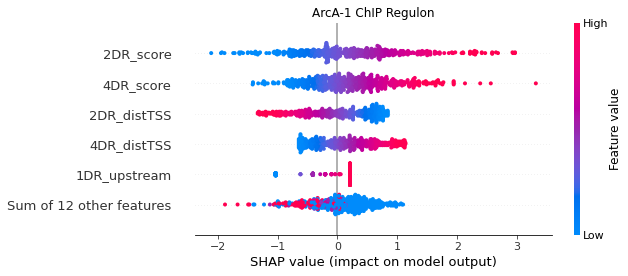

In [39]:
clf_chip = LogisticRegression(solver='saga',penalty = 'l1',max_iter=200,C=0.26,class_weight='balanced',verbose=1)
X_chip_fi = pd.DataFrame(
    X_DR, columns= DR_features,
    index=avg_DR.index
)
y_chip_fi = pd.Series( y_to_try['ArcA_regulon'] )
X_train, X_test, y_train, y_test = train_test_split( X_chip_fi, y_chip_fi, test_size=0.2, random_state=7)
clf_chip.fit(X_train, y_train)
explainer = shap.Explainer(clf_chip, X_train )
shap_values = explainer(X_test)
plt.title('ArcA-1 ChIP Regulon')
shap.plots.beeswarm(shap_values,max_display=6)

# 5. DR motif score distribution: I-Modulon(ICA regulon), ChIP regulon, and Random

In [40]:
def categoryToList( x, category ):
    result = {}
    for i in range(len(x)):
        if category[i] not in result.keys():
            result[ category[i] ] = [ x[i] ]
        else:
            result[ category[i] ].append( x[i] )
    return result

In [41]:
# Modified
import random
_2DR = []
_3DR = []
_4DR = []
chipmotif = []
ArcA_category = []
for i in range(len(avg_DR['ID'])):
    if avg_DR['ID'][i] in regulon_genes['ArcA']:
        ArcA_category.append('ChIP_Regulon')
        _2DR.append( avg_DR['2DR_score'][i])
        _3DR.append( avg_DR['3DR_score'][i])
        _4DR.append( avg_DR['4DR_score'][i])
        chipmotif.append(avg_features['ArcA score'][i])
        
    if avg_DR['ID'][i] in IM_genes['ArcA-1']: #ArcA to ArcA-1
        ArcA_category.append('ICA_Regulon')
        _2DR.append( avg_DR['2DR_score'][i])
        _3DR.append( avg_DR['3DR_score'][i])
        _4DR.append( avg_DR['4DR_score'][i])
        chipmotif.append( avg_features['ArcA score'][i] )

for i in range(200):
    rand_index = random.randint(100,2000)
    ArcA_category.append('Random')
    _2DR.append( avg_DR['2DR_score'][rand_index])
    _3DR.append( avg_DR['3DR_score'][rand_index])
    _4DR.append( avg_DR['4DR_score'][rand_index])
    chipmotif.append(avg_features['ArcA score'][rand_index])

In [ ]:
# from scipy.stats import f_oneway
# for i in range(4):
#     result = categoryToList( DR_features[i] , ArcA_category  )
#     p = f_oneway(result['ChIP_Regulon'],result['ICA_Regulon'],result['Random']).pvalue
#     print(p)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


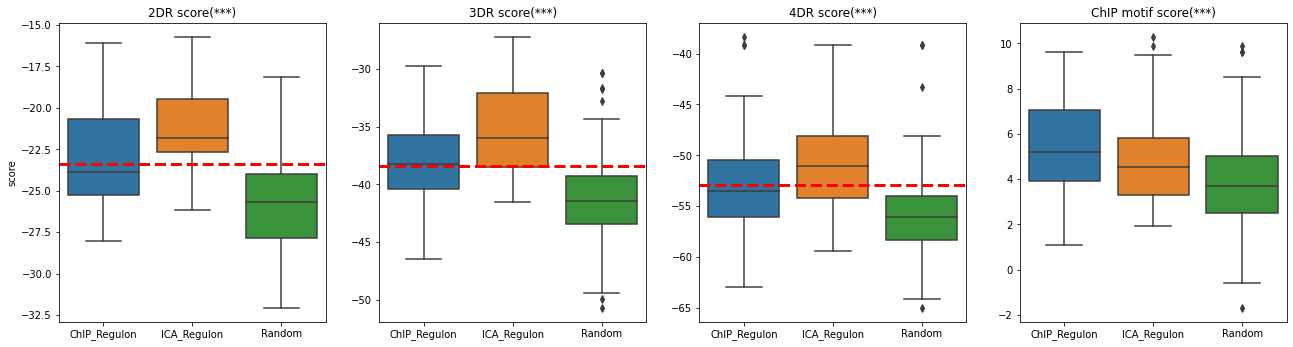

In [42]:
DR_features = [_2DR, _3DR,_4DR,chipmotif ]
titles = ['2DR score','3DR score', '4DR score','ChIP motif score']
fig, axs = plt.subplots(1,4,figsize= (22,5.5))
for i in range(4):
    sns.boxplot( ArcA_category , DR_features[i], ax = axs[i] )
    axs[i].set_title( titles[i]+'(***)')
    if i < 3:
        axs[i].axhline( y = cutoff[i+2], ls = '--', color = 'red',lw=3)
axs[0].set_ylabel('score')
plt.savefig('../data/Figure 3F.svg', bbox_inches='tight') 